## Example of 2D time-domain full waveform inversion on a horizontal reflector model with a constant density model

In this example, we will show how to use PySIT to conduct a 2D time-domain FWI on a horizontal reflector model with a constant density. The corresponding .py file can be found in ``/Demo/InversionHorizontalReflector2D_TimeDomain_ConstantDensity.py``

In [116]:
%matplotlib inline

Import necessary modules:

In [117]:
import time
import copy

import numpy as np
import matplotlib.pyplot as plt
import math
import os
from shutil import copy2
from mpl_toolkits.axes_grid1 import make_axes_locatable

import sys
import scipy.io as sio

from pysit import *
from pysit.gallery import horizontal_reflector
from pysit.util.io import *
from pysit.util.compute_tools import *

from pysit.util.parallel import *

### Define the physical domain, computational mesh and velocity models ###

1. Define perfectly matched layer(PML) boundaries in x and z directions with width of ``0.1 km`` and PML coefficient of ``1000`` by

    ``pmlx = PML(0.1, 1000)``

    ``pmlz = PML(0.1, 1000)``
    

    For more information about the PML object, we refer users to check ``/pysit/core/domain.py`` by

2. Define a 2D rectangular domain with the width of ``2 km`` and depth of ``1 km``. 
    
    ``x_config = (0.0, 2.0, pmlx, pmlx)`` (The physical domain of x direction starts at 0.0 km and ends at 2.0 km.)
    
    ``z_config = (0.0, 1.0, pmlz, pmlz)`` (The physical domain of z direction starts at 0.0 km and ends at 1.0 km.)
    
    ``d = RectangularDomain(x_config, z_config)``
    
    For more information about the RectangularDomain, we refer users to check ``/pysit/core/domain.py``.

3. Define the computational Cartesian mesh with ``201`` grids in ``x`` direction and ``101`` grids in ``z`` direction by
    
    ``m = CartesianMesh(d, 201, 101)`` (The computational mesh ``m`` meets the physical domain ``d``)
    
    For more information about the CartesianMesh object, we refer users to check ``/pysit/core/mesh.py``.
    
4. Generate the true velocity model and initial model for a Horizontal reflector model by

    ``C, C0, m, d = horizontal_reflector(m)``
    
    The output ``C`` is the true velocity model and ``C0`` is the initial model.
    
    For more information about the horizontal_reflecotr object, we refer users to check ``/pysit/gallery/horizontal_reflector.py``.
    


Text(0, 0.5, 'Z [km]')

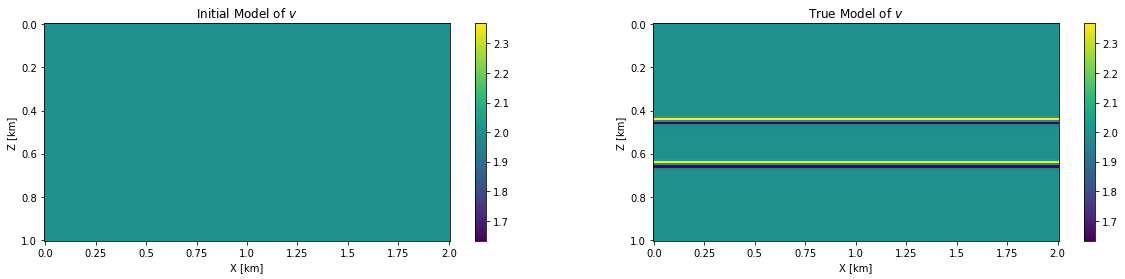

In [118]:
    pmlx = PML(0.1, 1000)
    pmlz = PML(0.1, 1000)

    x_config = (0.0, 2.0, pmlx, pmlx)
    z_config = (0.0, 1.0, pmlz, pmlz)

    d = RectangularDomain(x_config, z_config)

    m = CartesianMesh(d, 201, 101)
    
    C, C0, m, d = horizontal_reflector(m)
    
    clim = C.min(),C.max()
    plt.figure(figsize=(20,4))
    plt.subplot(1,2,1)
    vis.plot(C0, m, clim=clim)
    plt.title(r'Initial Model of $v$')
    plt.colorbar()
    plt.xlabel('X [km]')
    plt.ylabel('Z [km]')
    plt.subplot(1,2,2)
    vis.plot(C, m, clim=clim)
    plt.title(r"True Model of $v$")
    plt.colorbar()
    plt.xlabel('X [km]')
    plt.ylabel('Z [km]')

### Set up shots
1. Set up the shots object by:

    ``shots = equispaced_acquisition(m, RickerWavelet(10.0), sources=Nshots, source_depth=zpos,source_kwargs={},receivers='max',receiver_depth=zpos,receiver_kwargs={})``

    ``equispaced_acquisition`` - create a shots object with equially spaced acquisition

    ``m`` - computational mesh

    ``RickerWavelet(10.0)`` - a Ricker wavelet centered at ``10 Hz``

    ``sources`` - number of sources

    ``source_depth`` - the depth of sources

    ``receivers`` - number of receivers, if set to be ``max``, then the number of receivers equals to the number of grids in x direction.

    ``receiver_depth`` - the depth of receivers
    
    For more information about the ``equispaced_acquisition`` object, we refer the users to check ``/pysit/core/acquisition.py``. 
    
2. Set up the range of recording time by;

    ``trange = (0.0,2.0)``.
    


                                   



In [119]:
# Set up shots
    zmin = d.z.lbound
    zmax = d.z.rbound
    zpos = zmin + (1./10.)*zmax

    Nshots = 3

    shots = equispaced_acquisition(m,
                                   RickerWavelet(10.0),
                                   sources=Nshots,
                                   source_depth=zpos,
                                   source_kwargs={},
                                   receivers='max',
                                   receiver_depth=zpos,
                                   receiver_kwargs={}
                                   )
    
    shots_freq = copy.deepcopy(shots)


    # Define and configure the wave solver
    trange = (0.0,2.0)

<class 'float'>
3.0


### Define the wave-equation solver and the computational model object, and generate time-domain data 

1. In this example, we use the time-domain constant density acoustic wave as our target wave equation. We set up our wave equation solver by:

    ``solver = ConstantDensityAcousticWave(m, spatial_accuracy_order=2, trange=trange, kernel_implementation='cpp')``
                                     
    ``m`` - the computational mesh

    ``spatial_accuracy_order`` - the spatial accuray order for the numerical solver. Users can select one of the four values ``2, 4, 6, 8``. 

    ``trange`` - the range of the recording time

    ``kernel_implementattion`` - the implementation of the stencil kernel. When set it to be 'cpp', we use the stencil implemented in the language of ``C++``
    
    ``max_C`` - the maximal velocity used in the simulation to compute the CFL condition.
    
    For more information about the ``ConstantDensityAcousticWave`` object, we refer the users to check ``/pysit/solvers/wave_factory.py``
    
2. Create the velocity model object for the wave-quation solver by:

    ``base_model = solver.ModelParameters(m,{'C': C})``
    
    The model object ``base_model`` contains the information of the computational mesh and the velocity model ``C``.
    
3. Generate the time-domain data by:

    ``generate_seismic_data(shots, solver, base_model)``
    
    The generated data are stored in the object ``shots``. In order to check the data of the $i^{\text{th}}$ shot, you may need to use the command:
    
    ``data = shots[i].receivers.data``
    
    For more information about the ``generate_seismic_data`` function, we refer the users to check ``/pysit/modeling/data_modeling.py``.

In [120]:
    solver = ConstantDensityAcousticWave(m,
                                         spatial_accuracy_order=2,
                                         trange=trange,
                                         kernel_implementation='cpp',
                                         max_C = 3.0)
    
    solver.max_C = 3.0
    
    base_model = solver.ModelParameters(m,{'C': C})
    
    generate_seismic_data(shots, solver, base_model)
    
    data = shots[0].receivers.data
    
    t_smp = np.linspace(trange[0], trange[1], data.shape[0])
    

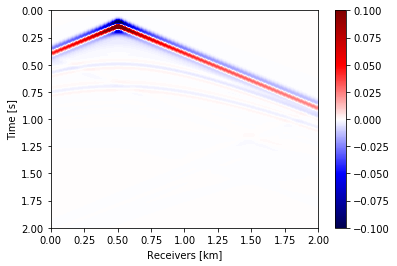

In [121]:
    fig=plt.figure()
    im1=plt.imshow(data, interpolation='nearest', aspect='auto', cmap='seismic', clim =[-.1,.1],
              extent=[0.0, 2.0, t_smp[-1], 0.0])
    plt.xlabel('Receivers [km]')
    plt.ylabel('Time [s]')
    plt.colorbar()
    

### Inversion 

After the data generation, we will show how to set up the inversion. 

1. **Set up the objective function object.**

 The first thing for the inversion is to set up the objective function. In this version of PySIT, we provide the following objective function options: ``Least-squares method``, ``Envelope method``, ``Cross-correlation method``, ``Optimal transportation method``, and ``FWI with extended imaging``. In order to use these objective functions, users can follow the follwoing instruction:

    **<1> *Least squares*:** for the least-squares method, the necessary input is the solver of the wave-equation. There are three optional inputs: 
    
    ``filter_op`` - the filtering oprerator used in the inversion. We will define one filtering operator in the following example.
    
    ``parallel_wrap_shot`` - the parallel wrapper for using parallel computing. The default is ``ParallelWrapShotNull``, which means that we do not use parallel computing.
    
    ``imaging_period`` - imaging period for computing the gradient. The default is ``1``, which means that we use each step of the wavefield to compute the gradient.
    
    To generate a Least-squares objective function, we can use the following command:
    
    ``objective = TemporalLeastSquares(solver, filter_op=filter_op1, parallel_wrap_shot=pwrap, imaging_period=1)``,
    
    where ``filter_op1`` and ``pwrap`` are predefined filtering operator and parallel wrapper, respectively.
    
    **<2> *Envelope method*:** for envelope method, the input arguments are almost the same as the Least-squares method. There is one one additional optional argument:
    
    ``envelope_power`` – the power for the envelope data. By default, we set it to be ``2``.
    
    To generate an objective function for the envelope method, we can use the following command:
    
    ``objective = TemporalEnvelope(solver, envelope_power=2.0, filter_op=filter_op1, parallel_wrap_shot=pwrap, imaging_period=1)``.
    
    **<3> *Cross-correlation method*:** for the cross-correlation method, the input arguments are the same as the Least-squares method. To generate an objective function for the cross-correlation method, we can use the following command:
    
    ``objective = TemporalCorrelate(solver, filter_op=filter_op, parallel_wrap_shot=pwrap, imaging_period=1)``.
    
    **<4> *Optimal transportation method*:** for the optimal transportation method, we provide four different tranformation options to transform the seismic data to a probability density function, i.e. ``Linear function``, ``Quadratic function``, ``Absolute function`` and ``exponential function``. We can set the input arguement ``transform_mode`` to select the tranformation function. There are four options for ``transform_mode`` - ``linear``, ``quadratic``, ``absolute``, and ``exponential``. 
    
    We can use the following commands to generate the objective function for each transformation option:
    
    [1] Linear function: 
    
    ``objective = TemporalOptimalTransport(solver, filter_op=filter_op1, parallel_wrap_shot=pwrap, imaging_period=1, transform_mode='linear', c_ratio=2.0)``,
    
    where ``c_ratio`` corresponds to the parameter $c$ in the linear function $f(x) = x + c$.
    
    [2] Quadratic function:
    
    ``objective = TemporalOptimalTransport(solver, filter_op=filter_op1, parallel_wrap_shot=pwrap, imaging_period=1, transform_mode='quadratic')``.
    
    [3] Absolute function:
    
    ``objective = TemporalOptimalTransport(solver, filter_op=filter_op1, parallel_wrap_shot=pwrap, imaging_period=1, transform_mode='absolute')``.
    
    [4] Exponential function:
    
    ``objective = TemporalOptimalTransport(solver, filter_op=filter_op1, parallel_wrap_shot=pwrap, imaging_period=1, transform_mode='exponential', exp_a=1.0)``.
    
    where the input argument ``exp_a`` correspons to the $a$ in the exponential function $f(x)=\exp(ax)$.  
    
    For more information about the objective functions, we recommend users to check the files in ``/pysit/objective_functions``.
    
2. **Define the filtering operator.**

    In PySIT, we provide the feature to define a band-pass filter to conduct band-pass filtering on the data. An example of generating a band-pass filter is as follows:
    
    ``filter_op = band_pass_filter(n_timesmp, T_max, freq_band, transit_freq_length=0.5, padding_zeros=True, nl=500, nr=500)``,
    
    where
    
    ``n_timesmp`` - number of the sampling points in time.
    
    ``T_max`` - the maximum recording time. 
    
    ``freq_band`` - freq_band = (min_freq, max_freq), which defines the lowest and highest frequency of the band-pass filter.
    
    ``transit_freq_length`` - the width of the transition band that allows the transition between the passband and the stopband of the signal in frequency domain. Here, we set the transition band width to be ``0.5 Hz``.
    
    ``padding_zeros`` - the flag to decide whether we need to pad zeros at the both sides of the signal.
    
    ``nl, nr`` - number of zeros padded at the left side (nl) and right side (nr) of the signal.
    
    For more information about the band_pass filter, we recommend users to check the file ``/pysit/util/compute_tool.py``.

3. **Define the parallel wrapper.**

    PySIT provides the feature to compute different shots in parallel. In oreder to activate this feature, we should define a parallel wrapper. We can define the parallel wrapper by the following command:
    
    ``pwrap = ParallelWrapShot()``.
    
    For more information about the parallel wrapper, we recommend users to check the file ``/pysit/util/parallel.py``.
    
    
Now, let us first define a Least-squares objective function as an example.    

In [122]:
    pwrap = ParallelWrapShot()

    n_timesmp = shots[0].receivers.data.shape[0]
    T_max = solver.tf
    freq_band =[1.0, 30.0]
    filter_op1 = band_pass_filter(n_timesmp, T_max, freq_band, transit_freq_length=0.5, padding_zeros=True, nl=500, nr=500)
    
    objective = TemporalLeastSquares(solver, filter_op=filter_op1, parallel_wrap_shot=pwrap, imaging_period=1)
    

4. **Define the optimization object.**

    After generating the objective function object, the next step is to generate the optimziation object. PySIT provides the following optimization algorithms: 

    <1>. projected gradient descent method, 
    
    <2>. projected quasi newton method, 
    
    <3>. Gauss-Newton method. 
    
    We can use the following command to generate the optimization object corresponding to the above algorithms. 
    
    [1]. Projected gradient descent method:
    
    ``invalg = PQN(objective, proj_op=Proj_Op)``,
    
    where the input argument ``proj_op`` is the projection operator that we decide to use in the inversion. It is an optional input argument. By default, we set ``proj_op=None``, which means we do not use any projection operator and the resulting algorithm is the basic gradient descent method. We will introduce how to generate a projcetion operator in the next cell.
    
    [2]. Projected quasi newton method:
    
    ``invalg = PQN(objective, proj_op=Proj_Op, memory_length=10)``,
    
    where the additional input argument ``memory_length`` denotes the number of previous iterations stored in the memory for l-BFGS method. Same as the projected gradient descent method, the default setting of ``proj_op`` is ``proj_op=None``.
    
    [3]. Gauss-Newton method:
    
    ``invalg = GaussNewton(objective, krylov_maxiter=50)``,
    
    where the additional input argument ``krylov_maxiter`` defines the maximal numbal of the krylov iterations used to solve the linearized problem.
    
    For More information about the optimization methods, we recommend users to check the directory ``/pysit/optimization``.
   
5. **Define the projection operator.**

    In the current version of PySIT, we provide two projection operators – ``BoxConstraintPrj`` and ``WaterVelocityPrj``. To generate the two operator, users can use the following commands:
    
    [1] Box Constraint projection:
        
    ``Proj_op1 = BoxConstraintPrj(bound)``, 
    
    where 
    
    ``bound = (v_min, v_max)`` denotes the lower and upper bound of the velocity.
    
    [2] Water Velocity Projection:
    
    ``Proj_op2 = WaterVelocityPrj(ModelSize, NumberofWaterLayer=10, WaterVel=1.5)``,
    
    where 
    
    ``ModelsSize = [nx, nz]`` denotes the size of the model,
    
    ``NumberofWaterLayer`` denotes the number of the water layer,
    
    ``WaterVel`` denotes the velocity of water.
    
    We also provide the feature to combine two projection operators. Users can achieve this by the following command:
    
    ``Proj_joint = JointPrj(Proj_op1, Proj_op2)``.
    
    For more information about the projection operator, we recommend users to check the file ``/pysit/optimization/projection.py``.
    
6. **Define the number of iterations.**

    We can define the number of iterations by ``nsteps = 5``.
    
7. **Set up status_configuration.**

    Please check the following python cell to check the setting of the status_configuration.

8. **Set up the line search type**.

    We recommend to use the backtrack line search by the following command: 
    
    ``line_search = 'backtrack'``.
    
9. **Set up the initial model**.

    We can set up the initial model by:
    
    ``initial_value = solver.ModelParameters(m,{'C': C0})``.

9. **Run the inversion**.

    After setting up all the necessary and optional arguments, we can conduct the inversion by:
    
    result = invalg(shots, initial_value, nsteps,
                    line_search=line_search,
                    status_configuration=status_configuration, verbose=True, write=False)
                    
    where, the argument ``write`` denotes whether the user wants to write the model of each iteration to the disk.
    
    
Now, let us use PQN as an example.

In [123]:
    bound = [1.5, 3.0]
    Proj_Op1 = BoxConstraintPrj(bound)
    invalg = PQN(objective, proj_op=Proj_Op1, memory_length=10)
    
    nsteps = 5
    status_configuration = {'value_frequency'           : 1,
                            'residual_frequency'        : 1,
                            'residual_length_frequency' : 1,
                            'objective_frequency'       : 1,
                            'step_frequency'            : 1,
                            'step_length_frequency'     : 1,
                            'gradient_frequency'        : 1,
                            'gradient_length_frequency' : 1,
                            'run_time_frequency'        : 1,
                            'alpha_frequency'           : 1,
                            }
    
    initial_value = solver.ModelParameters(m,{'C': C0})
    line_search = 'backtrack'
    
    result = invalg(shots, initial_value, nsteps,
                    line_search=line_search,
                    status_configuration=status_configuration, verbose=True)
    

Iteration 0
  gradnorm 4.061936398140651
  objective 0.0001918727301727482
  residual 0.019589422154456124
  Starting:  1.0 0.0001918727301727482
  Pass 1: a:1.0; 0.00018069284262843297 ?<= 0.0001918611551506131
  alpha 1.0
  run time 34.839987993240356s
Iteration 1
  gradnorm 3.8273961556421425
  objective 0.00018069284262843297
  residual 0.0190101469025588
  Starting:  1.0 0.00018069284262843297
  Pass 1: a:1.0; 0.00017755303082015245 ?<= 0.00018040804914148557
  alpha 1.0
  run time 35.61538004875183s
Iteration 2
  gradnorm 20.459042302138844
  objective 0.00017755303082015245
  residual 0.018844258054917018
  Starting:  1.0 0.00017755303082015245
  Pass 1: a:1.0; 7.457174032955706e-05 ?<= 0.00017730896892526857
  alpha 1.0
  run time 35.566407203674316s
Iteration 3
  gradnorm 5.5136533813908475
  objective 7.457174032955706e-05
  residual 0.012212431398338093
  Starting:  1.0 7.457174032955706e-05
  Pass 1: a:1.0; 6.50267822669593e-05 ?<= 7.455644545848402e-05
  alpha 1.0
  run ti

### Check result

We can check the history of the objective values by the following command:

``obj_vals = np.array([v for k,v in list(invalg.objective_history.items())])``.

We can check the final velocity model by the following command:

``v_final = result.C``.
   

Now, let us check the final results.

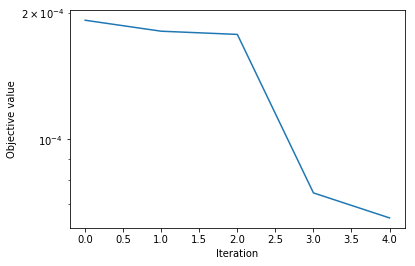

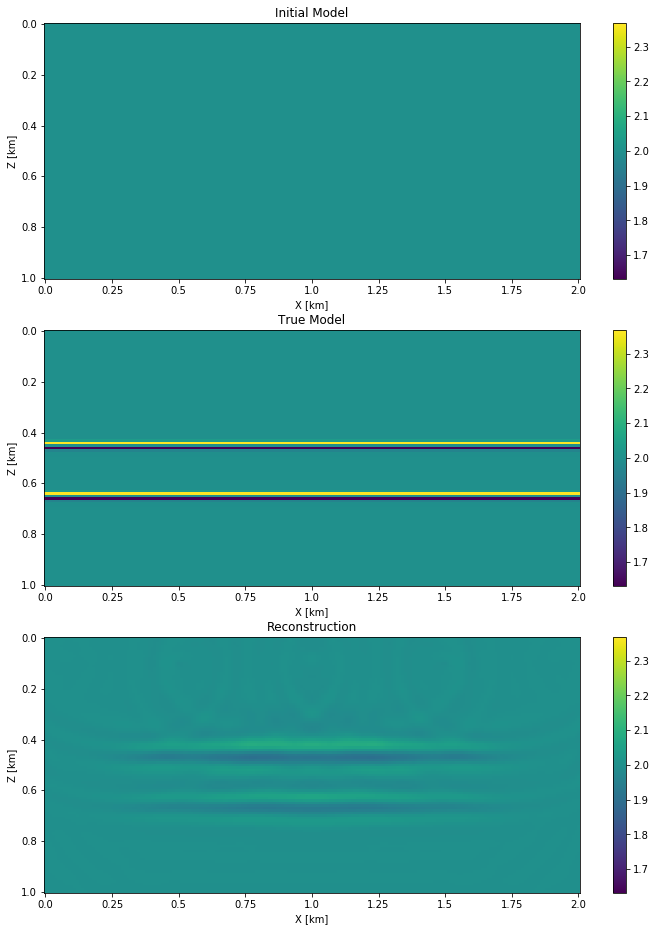

In [124]:
    obj_vals = np.array([v for k,v in list(invalg.objective_history.items())])

    plt.figure()
    plt.semilogy(obj_vals)
    plt.xlabel('Iteration')
    plt.ylabel('Objective value')
    
    clim = C.min(),C.max()

    # Do something to visualize the results
    plt.figure(figsize=(12,16))
    plt.subplot(3,1,1)
    vis.plot(C0, m, clim=clim)
    plt.title('Initial Model')
    plt.xlabel('X [km]')
    plt.ylabel('Z [km]')
    plt.colorbar()
    plt.subplot(3,1,2)
    vis.plot(C, m, clim=clim)
    plt.title('True Model')
    plt.xlabel('X [km]')
    plt.ylabel('Z [km]')
    plt.colorbar()
    plt.subplot(3,1,3)
    vis.plot(result.C, m, clim=clim)
    plt.title('Reconstruction')
    plt.xlabel('X [km]')
    plt.ylabel('Z [km]')
    plt.colorbar()

    plt.show()